# Load Model

In [6]:
import openvino as ov

core = ov.Core()

model = core.read_model(model='models/face-detection-adas-0001.xml')
compiled_model = core.compile_model(model = model, device_name="CPU")

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

print(f"Input shape: {input_layer.shape}")
print(f"Output shape: {output_layer.shape}")

Input shape: [1,3,384,672]
Output shape: [1,1,200,7]


# Preprocess New Input Data

### Call Image

In [14]:
import os
import cv2
import matplotlib.pyplot as plt

image = cv2.imread(os.path.join('data', 'person.jpg'))
print(image.shape)
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

image_height, image_width, image_channels = image.shape
image = cv2.resize(image, (int(image_width/5), int(image_height/5)))
print(image.shape)

cv2.imshow("Image", image)
cv2.waitKey()
cv2.destroyAllWindows()

(5472, 3648, 3)
(1094, 729, 3)


# Preprocess Data

In [18]:
import numpy as np

def preprocess(image):
    N, input_channels, input_height, input_width = input_layer.shape

    resized_image = cv2.resize(image, (input_width, input_height))
    transposed_image = resized_image.transpose(2, 0, 1)
    input_image = np.expand_dims(transposed_image, 0)

    return input_image

In [20]:
input_image = preprocess(image)

print(image.shape)
print(input_image.shape)

(1094, 729, 3)
(1, 3, 384, 672)


# Run Infere

In [22]:
results = compiled_model([input_image])[output_layer]

In [23]:
print(results.shape)

(1, 1, 200, 7)


In [39]:
print(results[0][0][-1])

[[0.         1.         0.9918893  ... 0.25737327 0.59240127 0.47395194]
 [0.         1.         0.02118394 ... 0.8015791  0.8361883  0.937317  ]
 [0.         1.         0.02039157 ... 0.1294643  0.141539   0.24232486]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Postprocess

In [46]:
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()

    scores = results[:, 2]
    boxes = results[:, -4:]

    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]

    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes * np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)

    return face_boxes, scores


In [47]:
confidence_threshold = .95
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
print(face_boxes)

[[254 281 431 518]]


In [48]:
print(scores)

[0.9918893]


In [51]:
def draw_faceboxes(image, face_boxes, scores):

    show_image = image.copy()

    for i in range(len(face_boxes)):

        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img=show_image, pt1=(xmin, ymin), pt2=(xmax, ymax), color=(0, 200, 0), thickness=2)

    return show_image


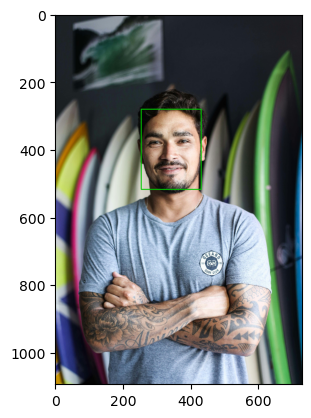

In [52]:
show_image = draw_faceboxes(image, face_boxes, scores)

plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

In [54]:
cv2.imshow("Image", show_image)
cv2.waitKey()
cv2.destroyAllWindows()

### Call Image

(6676, 4451, 3)


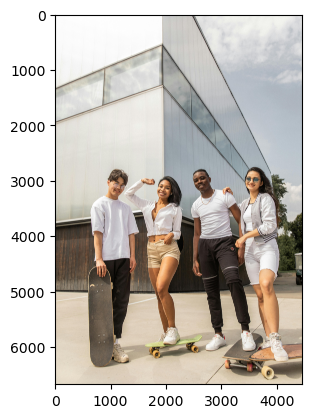

In [55]:
import os
import cv2
import matplotlib.pyplot as plt

image = cv2.imread(os.path.join('data', 'people.jpg'))
print(image.shape)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [56]:
image_height, image_width, image_channels = image.shape
image = cv2.resize(image, (int(image_width/5), int(image_height/5)))
print(image.shape)

(1335, 890, 3)


In [57]:
input_image = preprocess(image)

print(image.shape)
print(input_image.shape)

(1335, 890, 3)
(1, 3, 384, 672)


In [58]:
results = compiled_model([input_image])[output_layer]

In [59]:
confidence_threshold = .95
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
print(face_boxes)

[[369 597 418 669]
 [196 585 252 663]
 [687 564 741 638]
 [497 565 557 641]]


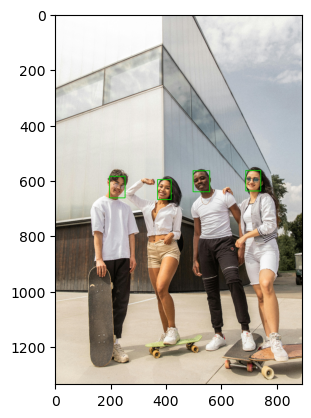

In [60]:
show_image = draw_faceboxes(image, face_boxes, scores)

plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))